# Ensemble/Voting Classification in Python with Scikit-Learn
ref：https://www.kaggle.com/c/titanic/submit

In [10]:
import pandas as pd
import numpy as np
import warnings

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier

In [16]:
training_data = pd.read_csv("data/train.csv")
testing_data = pd.read_csv("data/test.csv")
def get_nulls(training, testing):#分析dataset裡有多少null值
    print("Training Data:")
    print(pd.isnull(training).sum())
    print("Testing Data:")
    print(pd.isnull(testing).sum())

get_nulls(training_data, testing_data)

Training Data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Testing Data:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [17]:
#整理資料
# Drop the cabin column, as there are too many missing values
# Drop the ticket numbers too, as there are too many categories
# Drop names as they won't really help predict survivors
training_data.drop(labels=["Cabin","Ticket","Name"],axis=1,inplace=True)

testing_data.drop(labels=["Cabin","Ticket","Name"],axis=1,inplace=True)


# Taking the mean/average value would be impacted by the skew 有null的補值
# so we should use the median value to impute missing values
training_data["Age"].fillna(training_data["Age"].median(),inplace=True)
training_data["Embarked"].fillna("S",inplace=True)

testing_data["Age"].fillna(training_data["Age"].median(),inplace=True)
testing_data["Fare"].fillna(training_data["Fare"].median(),inplace=True)


get_nulls(training_data, testing_data)

Training Data:
PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
Testing Data:
PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64


In [13]:
training_data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S
887,888,1,1,female,19.0,0,0,30.0000,S
888,889,0,3,female,NaN,1,2,23.4500,S
889,890,1,1,male,26.0,0,0,30.0000,C


In [14]:
testing_data

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S
...,...,...,...,...,...,...,...,...
413,1305,3,male,NaN,0,0,8.0500,S
414,1306,1,female,39.0,0,0,108.9000,C
415,1307,3,male,38.5,0,0,7.2500,S
416,1308,3,male,NaN,0,0,8.0500,S


In [19]:
#資料轉換與標準化
# Fit the encoder on the data (Feature: Sex)
encoder_1 = LabelEncoder()
encoder_1.fit(training_data["Sex"])

# Transform and replace training data
training_sex_encoded = encoder_1.transform(training_data["Sex"])
training_data["Sex"] = training_sex_encoded
test_sex_encoded = encoder_1.transform(testing_data["Sex"])
testing_data["Sex"] = test_sex_encoded

# Fit the encoder on the data (Feature: Embarked)
encoder_2 = LabelEncoder()
encoder_2.fit(training_data["Embarked"])
training_Embarked_encoded = encoder_2.transform(training_data["Embarked"])
training_data["Embarked"] = training_Embarked_encoded
test_Embarked_encoded = encoder_2.transform(testing_data["Embarked"])
testing_data["Embarked"] = test_Embarked_encoded


# Any value we want to reshape needs be turned into array first
ages_train = np.array(training_data["Age"]).reshape(-1, 1)
fares_train = np.array(training_data["Fare"]).reshape(-1, 1)
ages_test = np.array(testing_data["Age"]).reshape(-1, 1)
fares_test = np.array(testing_data["Fare"]).reshape(-1, 1)


# Scaler takes arrays
scaler = StandardScaler()

training_data["Age"] = scaler.fit_transform(ages_train)
training_data["Fare"] = scaler.fit_transform(fares_train)
testing_data["Age"] = scaler.fit_transform(ages_test)
testing_data["Fare"] = scaler.fit_transform(fares_test)


In [20]:
training_data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,-0.565736,1,0,-0.502445,2
1,2,1,1,0,0.663861,1,0,0.786845,0
2,3,1,3,0,-0.258337,0,0,-0.488854,2
3,4,1,1,0,0.433312,1,0,0.420730,2
4,5,0,3,1,0.433312,0,0,-0.486337,2
...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,-0.181487,0,0,-0.386671,2
887,888,1,1,0,-0.796286,0,0,-0.044381,2
888,889,0,3,0,-0.104637,1,2,-0.176263,2
889,890,1,1,1,-0.258337,0,0,-0.044381,0


In [21]:
testing_data

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,1,0.371062,0,0,-0.497413,1
1,893,3,0,1.358985,1,0,-0.512278,2
2,894,2,1,2.544493,0,0,-0.464100,1
3,895,3,1,-0.221692,0,0,-0.482475,2
4,896,3,0,-0.616861,1,1,-0.417492,2
...,...,...,...,...,...,...,...,...
413,1305,3,1,-0.142658,0,0,-0.493455,2
414,1306,1,0,0.726714,0,0,1.314435,0
415,1307,3,1,0.687197,0,0,-0.507796,2
416,1308,3,1,-0.142658,0,0,-0.493455,2


In [22]:
#切割訓練資料集
# Now to select our training/testing data
X_features = training_data.drop(labels=['PassengerId', 'Survived'], axis=1)
y_labels = training_data['Survived']

print(X_features.head(5))
print(y_labels.head(5))

# Make the train/test data from validation

X_train, X_val, y_train, y_val = train_test_split(X_features, y_labels, test_size=0.1,random_state=12)

   Pclass  Sex       Age  SibSp  Parch      Fare  Embarked
0       3    1 -0.565736      1      0 -0.502445         2
1       1    0  0.663861      1      0  0.786845         0
2       3    0 -0.258337      0      0 -0.488854         2
3       1    0  0.433312      1      0  0.420730         2
4       3    1  0.433312      0      0 -0.486337         2
0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64


## Simple Averaging Approach

In [23]:
LogReg_clf = LogisticRegression()
DTree_clf = DecisionTreeClassifier()
SVC_clf = SVC()

LogReg_clf.fit(X_train, y_train)
DTree_clf.fit(X_train, y_train)
SVC_clf.fit(X_train, y_train)

LogReg_pred = LogReg_clf.predict(X_val)
DTree_pred = DTree_clf.predict(X_val)
SVC_pred = SVC_clf.predict(X_val)

averaged_preds = (LogReg_pred + DTree_pred + SVC_pred)//3
acc = accuracy_score(y_val, averaged_preds)
print(acc)

0.8


## Bagging Classification Example

In [27]:
def bagging_ensemble(model):
    #K_folds切分資料集 n_splits為將train資料集切割成幾堆
    k_folds = KFold(n_splits=20, random_state=12,shuffle=True)
    results = cross_val_score(model, X_train, y_train, cv=k_folds)
    print(results.mean())#計算出準確率

#設定執行模組
logreg_bagging_model=BaggingClassifier(base_estimator=LogReg_clf,n_estimators=50,random_state=12)
dtree_bagging_model=BaggingClassifier(base_estimator=DTree_clf,n_estimators=50,random_state=12)
random_forest=RandomForestClassifier(n_estimators=100,random_state=12)
extra_trees=ExtraTreesClassifier(n_estimators=100,random_state=12)

print("logreg =",end=" ")
bagging_ensemble(logreg_bagging_model)
print("dtree =",end=" ")
bagging_ensemble(dtree_bagging_model)
print("random_forest =",end=" ")
bagging_ensemble(random_forest)
print("extra_trees =",end=" ")
bagging_ensemble(extra_trees)

logreg = 0.7927134146341464
dtree = 0.8188719512195123
random_forest = 0.8113719512195123
extra_trees = 0.7963719512195122


## Boosting Classification Example

In [29]:
k_folds = KFold(n_splits=30, random_state=12,shuffle=True)
num_estimators = [20, 40, 60, 80, 100]

for i in num_estimators:
    ada_boost = AdaBoostClassifier(n_estimators=i,random_state=12)
    results = cross_val_score(ada_boost,X_train, y_train,cv=k_folds)
    print("Results for {} estimators:".format(i))
    print(results.mean())

Results for 20 estimators:
0.809781576448243
Results for 40 estimators:
0.8122981956315289
Results for 60 estimators:
0.8110636277302945
Results for 80 estimators:
0.8121082621082623
Results for 100 estimators:
0.8196581196581197


## voting\Stacking Classification Example

In [37]:
voting_clf = VotingClassifier(estimators=[('SVC', SVC_clf), ('DTree', DTree_clf), ('LogReg', LogReg_clf)], voting='hard')
#estimators(名稱，方法)
voting_clf.fit(X_train, y_train)

preds = voting_clf.predict(X_val)
acc = accuracy_score(y_val, preds)
l_loss = log_loss(y_val, preds)
f1 = f1_score(y_val, preds)

print("Accuracy is: " + str(acc))
print("Log Loss is: " + str(l_loss))
print("F1 Score is: " + str(f1))

Accuracy is: 0.8333333333333334
Log Loss is: 5.756516038980461
F1 Score is: 0.7761194029850748


In [32]:
voting_clf = VotingClassifier(estimators=[('SVC', SVC_clf), ('DTree', DTree_clf), ('LogReg', LogReg_clf)], voting='soft')
voting_clf.fit(X_train, y_train)
#preds = voting_clf.predict(X_val)
acc = accuracy_score(y_val, preds)
l_loss = log_loss(y_val, preds)
f1 = f1_score(y_val, preds)

print("Accuracy is: " + str(acc))
print("Log Loss is: " + str(l_loss))
print("F1 Score is: " + str(f1))

Accuracy is: 0.8222222222222222
Log Loss is: 6.140280221146135
F1 Score is: 0.7575757575757576


In [35]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
715,3,1,-0.796286,0,0,-0.494391,2
319,1,0,0.817561,1,1,2.059694,0
829,1,0,2.508257,0,0,0.962353,2
79,3,0,0.049062,0,0,-0.397241,2
484,1,1,-0.335187,1,0,1.185430,0
...,...,...,...,...,...,...,...
241,3,0,-0.104637,1,0,-0.336334,1
253,3,1,0.049062,1,0,-0.324253,2
390,1,1,0.510161,1,2,1.767741,2
667,3,1,-0.104637,0,0,-0.491874,2


In [34]:
testing_data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,-0.565736,1,0,-0.502445,2
1,2,1,1,0,0.663861,1,0,0.786845,0
2,3,1,3,0,-0.258337,0,0,-0.488854,2
3,4,1,1,0,0.433312,1,0,0.420730,2
4,5,0,3,1,0.433312,0,0,-0.486337,2
...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,-0.181487,0,0,-0.386671,2
887,888,1,1,0,-0.796286,0,0,-0.044381,2
888,889,0,3,0,-0.104637,1,2,-0.176263,2
889,890,1,1,1,-0.258337,0,0,-0.044381,0


In [36]:
test=testing_data.drop(labels=["PassengerId"],axis=1)
test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,0.371062,0,0,-0.497413,1
1,3,0,1.358985,1,0,-0.512278,2
2,2,1,2.544493,0,0,-0.464100,1
3,3,1,-0.221692,0,0,-0.482475,2
4,3,0,-0.616861,1,1,-0.417492,2
...,...,...,...,...,...,...,...
413,3,1,-0.142658,0,0,-0.493455,2
414,1,0,0.726714,0,0,1.314435,0
415,3,1,0.687197,0,0,-0.507796,2
416,3,1,-0.142658,0,0,-0.493455,2


In [41]:
submission_df=pd.DataFrame(columns=["PassengerId","Survived"])
submission_df["PassengerId"]=testing_data["PassengerId"]
preds=voting_clf.predict(test)
submission_df["Survived"]=preds
submission_df.to_csv("submission.csv",header=True,index=False)

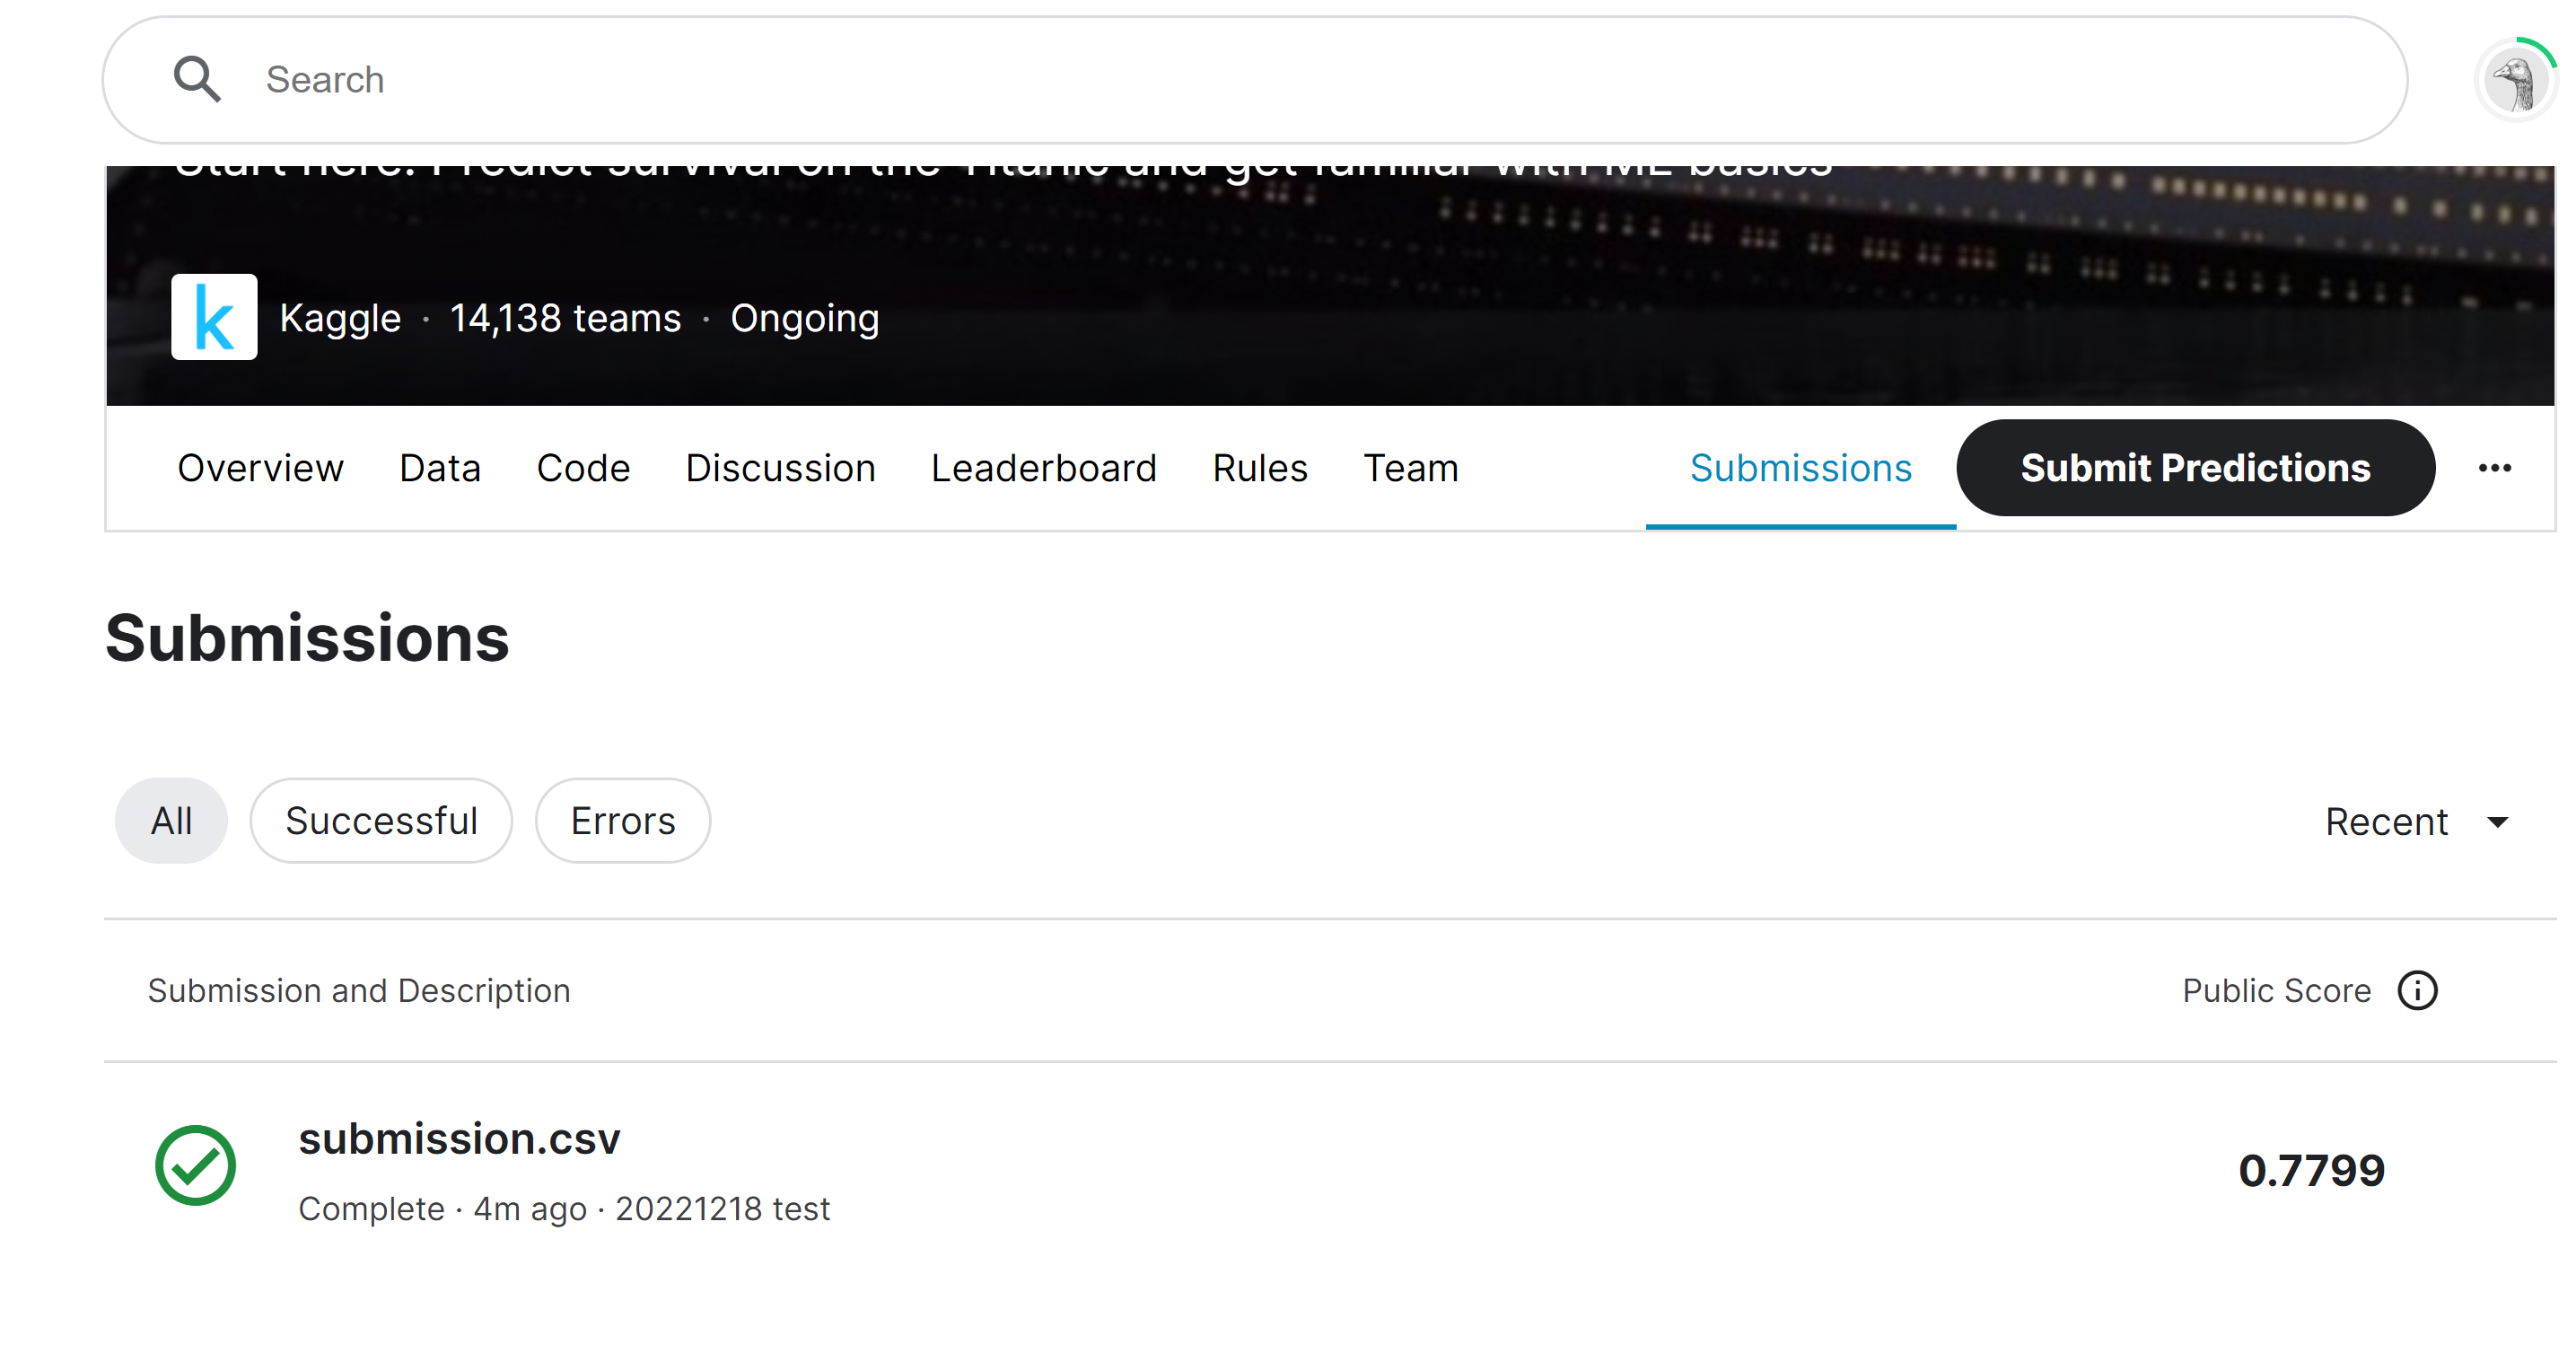
